In [1]:
import numpy as np
import pandas as pd
import sys
import os
import math
import matplotlib.pyplot as plt

def ReadPDB(PDBfile):
    f_o = open(PDBfile, "r")
    f_r = f_o.read().split("\n")
    f_o.close()
    
    XYZ = []
    X = []
    Y = []
    Z = []
    for line in f_r:
        if "ATOM" not in line:
            continue
        x = float(line[30:38])
        y = float(line[38:46])
        z = float(line[46:54])
        XYZ.append([x, y, z])
    XYZ = np.array(XYZ)
    return XYZ

## Obtain PPI file information

In [2]:
res = pd.read_csv("../data/trusted_PPI_pairs.txt",sep = "\t")
res_array = np.array(res)
res_array

array([['DR_0001', 'DR_0856'],
       ['DR_0001', 'DR_2410'],
       ['DR_0001', 'DR_1244'],
       ...,
       ['DR_A0352', 'DR_A0354'],
       ['DR_A0352', 'DR_A0353'],
       ['DR_A0353', 'DR_A0354']], dtype=object)

## wild-type

### spatial distance of all bins 

In [3]:
XYZ1 = ReadPDB('../data/reconstruction_structure_files/wt_chr_all.pdb')
def GetDistances(XYZ):
    D = []
    bin_num = XYZ.shape[0]
    for i in range(bin_num):
        for j in range(bin_num):
            if i>j:
                dis = math.sqrt((XYZ[i, 0] - XYZ[j, 0]) ** 2 + (XYZ[i, 1] - XYZ[j, 1]) ** 2 + (XYZ[i, 2] - XYZ[j, 2]) ** 2)
                D.append([i, j, dis])
            
    dis_ALL = []
    for line in D:
        dis_ALL.append(line[2])
    return dis_ALL
wt_dis_ALL = GetDistances(XYZ1)
print(np.mean(wt_dis_ALL))
print(len(wt_dis_ALL))

11.799623858884177
187578


In [4]:
import re

def _get_attr(attributes, attr_id, ignore=False):
    """
    Helper function for parsing GFF annotations

    Parameters
    ----------
    attributes : str
        Attribute string
    attr_id : str
        Attribute ID
    ignore : bool
        If true, ignore errors if ID is not in attributes (default: False)

    Returns
    -------
    str, optional
        Value of attribute
    """

    try:
        return re.search(attr_id + "=(.*?)(;|$)", attributes).group(1)
    except AttributeError:
        if ignore:
            return None
        else:
            raise ValueError("{} not in attributes: {}".format(attr_id, attributes))
gff_files = [os.path.join('../data/GCF_000008565.1_ASM856v1_genomic.gff')]

for gff in gff_files:
    with open(gff, "r") as f:
        lines = f.readlines()

    # Read GFF
    names = [
        "accession",
        "source",
        "feature",
        "start",
        "end",
        "score",
        "strand",
        "phase",
        "attributes",
        ]
    DF_gff = pd.read_csv(gff, sep="\t", names=names)
    # Filter for CDSs 
    DF_cds = DF_gff[DF_gff['feature']=='CDS']
    # Also filter for genes to get old_locus_tag
    DF_gene = DF_gff[DF_gff.feature == "gene"].reset_index()
    DF_gene["locus_tag"] = DF_gene.attributes.apply(_get_attr, attr_id="locus_tag", ignore=True)
    DF_gene["old_locus_tag"] = DF_gene.attributes.apply(_get_attr, attr_id="old_locus_tag", ignore=True)
    DF_gene = DF_gene[["locus_tag", "old_locus_tag"]]
    DF_gene = DF_gene[DF_gene.locus_tag.notnull()]

    # Sort by start position
    DF_cds = DF_cds.sort_values("start")

    # Extract attribute information
    DF_cds["locus_tag"] = DF_cds.attributes.apply(_get_attr, attr_id="locus_tag")

    DF_cds["gene_name"] = DF_cds.attributes.apply(_get_attr, attr_id="gene", ignore=True)

    DF_cds["gene_product"] = DF_cds.attributes.apply(_get_attr, attr_id="product", ignore=True)

    DF_cds["ncbi_protein"] = DF_cds.attributes.apply(_get_attr, attr_id="protein_id", ignore=True)

    # Merge in old_locus_tag
    DF_annot = pd.merge(DF_cds, DF_gene, how="left", on="locus_tag", sort=False)

DF_annot1 = DF_annot[DF_annot['accession']=='NC_001263.1']
DF_annot1 = DF_annot1.drop_duplicates(subset='locus_tag',keep='first',inplace=False)
DF_annot1 = DF_annot1.reset_index(drop=True)
keep_cols = ['accession','locus_tag','start','end']
DF_annot1 = DF_annot1[keep_cols]

gene_tag = pd.read_csv("../data/new_old_gene_tag.txt", sep='\t', names=['locus_tag','old_locus_tag'])
gene_tag1 = pd.merge(DF_annot1, gene_tag, how="left", on="locus_tag", sort=False)
gene_tag1['start_bin'] = (gene_tag1['start'] / 5000).astype(int)
# print(gene_tag1.dtypes)
print(len(gene_tag1["old_locus_tag"].unique()))
gene_tag1

2674


,accession,locus_tag,start,end,old_locus_tag,start_bin
0,NC_001263.1,DR_RS00005,93.0,1179.0,DR_0001,0
1,NC_001263.1,DR_RS00010,1904.0,3304.0,DR_0002,0
2,NC_001263.1,DR_RS00015,3556.0,4251.0,DR_0003,0
3,NC_001263.1,DR_RS00020,4387.0,5430.0,DR_0004,0
4,NC_001263.1,DR_RS00025,5438.0,6115.0,DR_0005,1
...,...,...,...,...,...,...
2669,NC_001263.1,DR_RS13555,2642825.0,2643265.0,DR_2632,528
2670,NC_001263.1,DR_RS13560,2643262.0,2644083.0,DR_2633,528
2671,NC_001263.1,DR_RS13565,2644270.0,2645499.0,DR_2634,528
2672,NC_001263.1,DR_RS13570,2645698.0,2647146.0,DR_2635,529


In [5]:
DF_annot2 = DF_annot[DF_annot['accession']=='NC_001264.1']
DF_annot2 = DF_annot2.drop_duplicates(subset='locus_tag',keep='first',inplace=False)
DF_annot2 = DF_annot2.reset_index(drop=True)
keep_cols = ['accession','locus_tag','start','end']
DF_annot2 = DF_annot2[keep_cols]

gene_tag = pd.read_csv("../data/new_old_gene_tag.txt", sep='\t', names=['locus_tag','old_locus_tag'])
gene_tag2 = pd.merge(DF_annot2, gene_tag, how="left", on="locus_tag", sort=False)
gene_tag2['start_bin'] = (gene_tag2['start'] / 5000).astype(int)+530
# print(gene_tag2.dtypes)
print(len(gene_tag2["old_locus_tag"].unique()))

gene_tag = gene_tag1.append(gene_tag2)
gene_tag = gene_tag.reset_index(drop=True)
gene_tag

371


,accession,locus_tag,start,end,old_locus_tag,start_bin
0,NC_001263.1,DR_RS00005,93.0,1179.0,DR_0001,0
1,NC_001263.1,DR_RS00010,1904.0,3304.0,DR_0002,0
2,NC_001263.1,DR_RS00015,3556.0,4251.0,DR_0003,0
3,NC_001263.1,DR_RS00020,4387.0,5430.0,DR_0004,0
4,NC_001263.1,DR_RS00025,5438.0,6115.0,DR_0005,1
...,...,...,...,...,...,...
3040,NC_001264.1,DR_RS15430,406320.0,407234.0,DR_A0364,611
3041,NC_001264.1,DR_RS15435,407294.0,408195.0,DR_RS15435,611
3042,NC_001264.1,DR_RS15440,408201.0,409388.0,DR_A0367,611
3043,NC_001264.1,DR_RS15445,409381.0,410466.0,DR_A0368,611


###  spatial distance of the bin containing protein-protein interaction

In [6]:
gene_tag_dict = dict(zip(gene_tag['old_locus_tag'], gene_tag['start_bin']))
PPI = []
for line in res_array:
    if line[0] in gene_tag_dict.keys() and line[1] in gene_tag_dict.keys():
        bin1 = gene_tag_dict[line[0]]
        bin2 = gene_tag_dict[line[1]]
        PPI.append([line[0], bin1, line[1], bin2])

print(len(PPI))

def PPI_Dist(PPI, XYZ):
    d = []
    for line in PPI:
        i = line[1]
        j = line[3]
        dis = math.sqrt((XYZ[i, 0] - XYZ[j, 0]) ** 2 + (XYZ[i, 1] - XYZ[j, 1]) ** 2 + (XYZ[i, 2] - XYZ[j, 2]) ** 2)
        d.append([i, j, dis])
        
    dis_PPI = []
    for line in d:
        dis_PPI.append(line[2])
    return dis_PPI

wt_dis_PPI = PPI_Dist(PPI, XYZ1)
print(np.mean(wt_dis_PPI))
wt_dis_PPI

2987
9.700675937754506


[11.986238192193579,
 5.062856209690335,
 14.196783790704147,
 8.31167185348411,
 20.664681052462434,
 5.134304821492391,
 20.899257905485545,
 5.020468603626558,
 4.950410690033706,
 6.704992841159489,
 14.126817688354302,
 6.913265509149782,
 6.208505536761646,
 12.874589741036411,
 14.073020535762746,
 10.498112497015832,
 6.954066795767782,
 0.0,
 12.50084769125678,
 4.376785806959258,
 4.376785806959258,
 12.50084769125678,
 21.444262705908077,
 6.8426773999656,
 9.382657352797233,
 2.9239476739504076,
 0.4409444409446619,
 6.877336475700457,
 4.569231992359329,
 9.156363907141307,
 4.917379078330245,
 8.868110509009233,
 7.046575125548581,
 9.348258607890562,
 2.8519659885770023,
 7.0095062593595,
 11.630977860867933,
 12.57604747128445,
 7.38840882734571,
 11.441355251892146,
 4.917379078330245,
 12.55310200707379,
 12.57604747128445,
 12.44297239408655,
 7.046575125548581,
 12.711978838874773,
 21.003626591615078,
 5.024345629034691,
 12.512750137359891,
 7.110573113329193,
 7.

In [7]:
from scipy import stats
print(stats.ranksums(wt_dis_ALL, wt_dis_PPI, alternative='two-sided'))
stats.ttest_ind(wt_dis_ALL, wt_dis_PPI, equal_var=False)

RanksumsResult(statistic=17.1815566865109, pvalue=3.649842182991138e-66)


Ttest_indResult(statistic=18.448208843841474, pvalue=3.6951283824724736e-72)

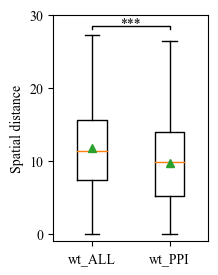

In [8]:
plt.rc('font',family='Times New Roman')

fig = plt.figure(figsize=(2,3),dpi=100)
ax = fig.add_subplot(111)
data = (list(wt_dis_ALL), list(wt_dis_PPI))
label=['wt_ALL','wt_PPI']
ax.boxplot(data, labels=label, vert=True, showmeans=True, positions=[0.2,0.6])
ax.set_xlim([0,0.8])
ax.set_ylim([-1,30])
plt.ylabel('Spatial distance')
plt.yticks([0,10,20,30], [0,10,20,30])
ax.plot([0.2, 0.2, 0.6, 0.6], [28, 28.5, 28.5, 28], lw=1, c="k") 
ax.text(0.4, 27.8, "***", ha='center', va='bottom', color="k")
plt.savefig("../pictures/wt_PPI_dist_boxplot.jpg", bbox_inches='tight', dpi=300)

##  ultraviolet irradiation

In [9]:
XYZ2 = ReadPDB('../data/reconstruction_structure_files/UV_chr_all.pdb')

uv_dis_ALL = GetDistances(XYZ2)
print(np.mean(uv_dis_ALL))

uv_dis_PPI = PPI_Dist(PPI, XYZ2)
print(np.mean(uv_dis_PPI))

print(stats.ranksums(uv_dis_ALL, uv_dis_PPI, alternative='two-sided'))
stats.ttest_ind(uv_dis_ALL, uv_dis_PPI, equal_var=False)

12.635229562971329
10.152642193617567
RanksumsResult(statistic=18.368024914996095, pvalue=2.368761574269045e-75)


Ttest_indResult(statistic=19.768007914028335, pvalue=5.474722623567635e-82)

## ΔDr_ebfC

In [10]:
XYZ3 = ReadPDB('../data/reconstruction_structure_files/ebfC_chr_all.pdb')

dr_dis_ALL = GetDistances(XYZ3)
print(np.mean(dr_dis_ALL))

dr_dis_PPI = PPI_Dist(PPI, XYZ3)
print(np.mean(dr_dis_PPI))

print(stats.ranksums(dr_dis_ALL, dr_dis_PPI, alternative='two-sided'))
stats.ttest_ind(dr_dis_ALL, dr_dis_PPI, equal_var=False)

12.866884140061849
10.320109546113754
RanksumsResult(statistic=18.117581507810918, pvalue=2.315519670022911e-73)


Ttest_indResult(statistic=18.28985336595605, pvalue=5.039324028796678e-71)

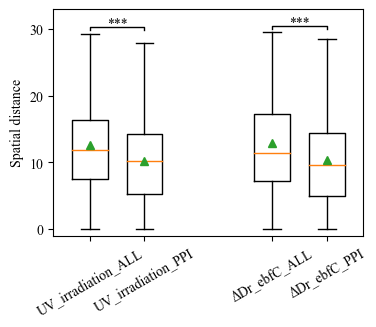

In [11]:
plt.rc('font',family='Times New Roman')

fig = plt.figure(figsize=(4,3),dpi=100)
ax = fig.add_subplot(111)
data = (list(uv_dis_ALL), list(uv_dis_PPI), list(dr_dis_ALL), list(dr_dis_PPI))
label=['UV_irradiation_ALL', 'UV_irradiation_PPI', 'ΔDr_ebfC_ALL', 'ΔDr_ebfC_PPI']
ax.boxplot(data, labels=label, vert=True, showmeans=True, positions=[0.2,0.5,1.2,1.5], showfliers=False)
ax.set_xlim([0,1.7])
ax.set_ylim([-1,33])
plt.ylabel('Spatial distance')
plt.yticks([0,10,20,30], [0,10,20,30])
ax.plot([0.2, 0.2, 0.5, 0.5], [29.8, 30.3, 30.3, 29.8], lw=1, c="k") 
ax.text(0.35, 29.7, "***", ha='center', va='bottom', color="k")

ax.plot([1.2, 1.2, 1.5, 1.5], [30, 30.5, 30.5, 30], lw=1, c="k") 
ax.text(1.35, 29.9, "***", ha='center', va='bottom', color="k")
plt.xticks(rotation=30)

plt.savefig("../pictures/uv_ebfC_PPI_dist_boxplot.jpg", bbox_inches='tight', dpi=300)